# Machine Learning Applications - Data Understanding

<p> Practical examples for machine learning applications lecture No. 7 - Data Understanding </p>

Author: 
 Henrik Simon - 2019-11-29

<h4> Contents </h4>

 1. Data Understanding <font color="red">- see Jupyter notebook "Data Exploration"</font>
 2. Data Preprocessing
 3. Feature Engineering
 
 How to use: This notebook is only partly automated. After loading the data in chapter 1, you have to choose which preprocessing step you want to do (and if you want to do any). You then either run through chapter 2.1, 2.2 or 2.3. The wrapper (2.4) works slightly different as it includes one machine learning algorithm directly. In chapter 3 you can then evaluate the different proprocessing methods and save the results in order to compare the methods against each other.

First, we need to import the necessary python libraries:

In [ ]:
# Standard data handling libraries
import pandas as pd
import numpy as np

# Standard plotting tools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection

# Some data preparation libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
from sklearn.utils.multiclass import unique_labels
from sklearn.decomposition import PCA
from mlxtend.feature_selection import SequentialFeatureSelector
# Not included in anaconda suite, use "conda install -c conda-forge mlxtend" to install

# Wizzards: Machine learning tools
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.externals import joblib

# Fancy additional stuff - maybe not installed
from tqdm import tqdm_notebook as tqdm
# from IPython.display import display, clear_output

## 1. Load your data

<p> First we will again load the data and get an overview of the recorded parameters. More detailed examples of Data Understanding can be found in the Jupyter Notebook "Data exploration". The basic idea is to analyse and describe the dataset with classical statistical methods. In this notebook, we will focus on the preprocessing part and will only plot the most meaningful graphics and parameters.  

<p> We now start with importing the two dataset. The first on will contain samples of the light weight container, the second one will contain samples of the heavy weight container. </p>

In [ ]:
"""PFAD ANPASSEN"""
# Import files
df_light_full = pd.read_csv("Matlab_Data_Training_output_leicht.csv", header=None)
df_heavy_full = pd.read_csv("Matlab_Data_Training_output_schwer.csv", header=None)

# Rename columns names
df_light_full.columns = ['DEV', 't', 'var_1', 'var_2', 'var_3']
df_heavy_full.columns = ['DEV', 't', 'var_1', 'var_2', 'var_3']

# Drop NaN
df_heavy_full = df_heavy_full.dropna()
df_light_full = df_light_full.dropna()

# Show first values of dataset (validates correct formatting)
df_heavy_full.head(3) 

The Data contains three columns:
 - Device name
 - timestep (counter)
 - Three acceleration parameters for x, y, z axis
    
The latter three parameters will represent the X-Values in our machine learning problem. We will add a Y-Value manually by creating the labels "light" or "heavy" represented by the scalar values 0 or 1. With concat (or concatenate) we will fusion the two datasets.

In [ ]:
y1 = np.zeros(len(df_light_full.index))
y2 = np.ones(len(df_heavy_full.index))

y = np.concatenate([y1, y2])

x_pd = pd.concat([df_light_full, df_heavy_full])

x = x_pd[["var_1", "var_2", "var_3"]].values


# we split the entire dataset into test and training. The dataset is shuffled and samples are picked randomly
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

<b> ----> Go to Chapter 3  and run sections for checking the classification results without further preprocessing! </b>

Alright. Through the visual inspection in Data exploration we know, that we saw slightly differences in the distributions of the first variable. We will repeat this plot.

In [ ]:
plt.figure(figsize=(20,10))

sns.distplot(df_light_full['var_1'], norm_hist=True, label='Light')
sns.distplot(df_heavy_full['var_1'], norm_hist=True, label='heavy')
plt.xlabel('Var1 = Acc in x-direction')
plt.legend()

# 2. Data Preprocessing

<h3>2.1 Simplest version of Feature Engineering: Moving mean </h3>

The easiest way of generating synthetic features is to just take statistical representations or filtering methods. In this case, we will apply a moving average/mean filter on the data with a windows size of 100 samples. Additionally we will compute the standard deviation of this window and take it as input variable as well.

In [ ]:
w_len = 100

x_l = df_light_full[['var_1', 'var_2', 'var_3']].values
x_h = df_heavy_full[['var_1', 'var_2', 'var_3']].values

xx_l = np.zeros([1,6])
for ii in np.arange(w_len,len(x_l)):
    values_l = np.array(x_l[ii-w_len:ii])
    xx_mean = np.mean(values_l, axis=0)
    xx_std  = np.std(values_l, axis=0)
    
    new_vals = np.concatenate([xx_mean, xx_std])
    xx_l     = np.vstack((xx_l, new_vals))
    
xx_h = np.zeros([1,6])
for ii in np.arange(w_len,len(x_h)):
    values_h = np.array(x_h[ii-w_len:ii])
    xx_mean = np.mean(values_h, axis=0)
    xx_std  = np.std(values_h, axis=0)
    
    new_vals = np.concatenate([xx_mean, xx_std])
    xx_h     = np.vstack((xx_h, new_vals))


Okay, well done. Now let's check out the influence on the time series...

In [ ]:
plt.figure()
plt.plot(xx_h[:,0])

In [ ]:
plt.figure()
plt.plot(df_heavy_full.var_1)

...And maybe more interesting on the statistical distribution

In [ ]:
plt.figure(figsize=(20,10))

sns.distplot(xx_l[:,0], norm_hist=True, label=['light'])
sns.distplot(xx_h[:,0], norm_hist=True, label=['heavy'])
plt.xlabel('Var1 = Acc in x-direction')
plt.legend()

Finally, we will again sort the data and bring it to the right order. In the last step we split the data already into training and test set and can then go to chapter 3 for evaluation.

In [ ]:
y1 = np.zeros(len(xx_l))
y2 = np.ones(len(xx_h))

y = np.concatenate([y1, y2])

x = np.concatenate([xx_l, xx_h])

# we split the entire dataset into test and training. The dataset is shuffled and samples are picked randomly
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

<b> ----> Go to Chapter 3 for evaluation !! </b>

<h3> 2.2 Another Preprocessing: Fast Fourier Transformation </h3>
A Fourier Transformation is often suitable for vibration data. It transforms the time series of a given window size into the frequency domain and may reveal new insights. Especially when investigating the technical health status and for diagnosis and prognosis topics, this method is very popular.

In [ ]:
# Set window length / sampling frequency
Fs = 100

x_l = df_light_full[['var_1', 'var_2', 'var_3']].values
x_h = df_heavy_full[['var_1', 'var_2', 'var_3']].values

ampl_l = np.zeros([3,(len(x_l)-100+2),51])
for zz in tqdm(range(3)):
    ampl_l0 = np.zeros([1,51])
    for ii in tqdm(range(len(x_l[:,zz])-100)):
        Y = np.fft.fft(x_l[ii:(ii+100),zz])

        P2 = np.abs(Y/len(Y))
        P1 = P2[0:(len(Y)//2+1)]
        f = np.arange((len(Y)+1)//2)*Fs/len(Y)

        ampl_l0 = np.vstack((ampl_l0, P1))
    ampl_l[zz,:,:] = np.vstack((ampl_l0, P1))
    
    
ampl_h = np.zeros([3,(len(x_h)-100+2),51])
for zz in tqdm(range(3)):
    ampl_h0 = np.zeros([1,51])
    for ii in tqdm(range(len(x_h[:,zz])-100)):
        Y = np.fft.fft(x_h[ii:(ii+101),zz])

        P2 = np.abs(Y/len(Y))
        P1 = P2[0:(len(Y)//2+1)]
        f = np.arange((len(Y)+1)//2)*Fs/len(Y)

        ampl_h0 = np.vstack((ampl_h0, P1))
    ampl_h[zz,:,:] = np.vstack((ampl_h0, P1))

We can plot the frequency spectrum at different timesteps. As the sampling frequency is only 100Hz, we can only calculate frequencies up to 50Hz (Nyquist-Shannon!).

In [ ]:
plt.figure()
plt.plot(f, ampl_l[1,600,:])
plt.title('Frequency spectrum')
plt.xlabel('Frquency in Hz')
plt.ylabel('Amplitude')

Finally, again combine the generated data in one array and then go to Chapter 3 for evaluation

In [ ]:
y1 = np.zeros(len(ampl_l[0]))
y2 = np.ones(len(ampl_h[0]))

y = np.concatenate([y1, y2])


all_ampl_l = np.concatenate([ampl_l[0,:,:], ampl_l[1,:,:], ampl_l[2,:,:]], axis=1)
all_ampl_h = np.concatenate([ampl_h[0,:,:], ampl_h[1,:,:], ampl_h[2,:,:]], axis=1)
    
x = np.concatenate([all_ampl_l, all_ampl_h])

# we split the entire dataset into test and training. The dataset is shuffled and samples are picked randomly
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
all_ampl_l.shape

In [ ]:
plt.figure()
plt.plot(all_ampl_h[:,147])

In [ ]:
plt.figure(figsize=(12,6))

sns.distplot(all_ampl_l[:,147], norm_hist=True, label=['light'])
sns.distplot(all_ampl_h[:,147], norm_hist=True, label=['heavy'])
# plt.xlabel('Var1 = Acc in x-direction')
plt.legend()

<b> ----> Go to Chapter 3 for evaluation !! </b>

<h3> 2.3 Next: Principal Component analysis - PCA </h3>

We will use the scikit learn function for this operation. In contrast to the methods showed before, we need to split the training and test dataset before applying the method. Otherwise information from the test dataset will be captured in the preprocessing step and will bias our evaltuation. 

Steps:
- Define the desired number of components you want to keep (number of features)
- Standardize your data
- Split into training and test set
- Apply (fit) the PCA on the training set
- Transform also your test set
- Ready to go and evaluate!

In [ ]:
# Define number of components that we want to use for the PCA:
n_PC = 3

# Standardize the features
x_std = StandardScaler().fit_transform(x)

# Train into training and test dataset (usually this happens in chapter 3, but as this is a method which uses the)
x_pca_train, x_pca_test, y_train, y_test = train_test_split(x_std, y, test_size=0.2, random_state=42)

# Perform PCA -> dimensionality reduction down to 2D)
pca = PCA(n_components=n_PC)

# Fit (and transform training set)
pc_train = pca.fit_transform(x_pca_train)
# Transform test set:
pc_test = pca.transform(x_pca_test)


print("The explained variance per PC is: ", pca.explained_variance_ratio_)
print("We lost", 100*np.round(1 - np.sum(pca.explained_variance_ratio_), decimals=4), "% of the information by cutting of after the", n_PC, ". PC.")

# Just for plotting: create dataframe object and add target (labels)
principalDF = pd.DataFrame(data = pc_train, columns = ['pc1', 'pc2', 'pc3'])
pca_data = pd.DataFrame(y_train, columns=['label'])
finalDF = pd.concat([principalDF, pca_data["label"]], axis = 1)


"""Plot PCA results"""

fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
# ax.set_title('2 component PCA', fontsize = 20)

ax.scatter(finalDF['pc1'].loc[finalDF['label']==0],
           finalDF['pc2'].loc[finalDF['label']==0], alpha=0.2, label='light')
ax.scatter(finalDF['pc1'].loc[finalDF['label']==1],
           finalDF['pc2'].loc[finalDF['label']==1], alpha=0.2, label='heavy')
ax.set_ylim(-4,3)
ax.legend()
ax.grid()
plt.plot()

# Safe results (transformed/reduced data) for evaluation
x_train = pc_train
x_test = pc_test

In [ ]:
plt.figure(figsize=(12,6))

sns.distplot(finalDF['pc1'].loc[finalDF['label']==0], norm_hist=True, label='Light')
sns.distplot(finalDF['pc1'].loc[finalDF['label']==1], norm_hist=True, label='heavy')
plt.legend()

If you want, you can also check the feature importance inside the principal components

In [ ]:
abs(pca.components_)

<h3> 2.4 Wrapper: Feature selection </h3>

The third approach, we want to investigate, comes from the field of feature selection. In this case we will let a Wrapper algorithm select the most important features for our problem. In general, this can be done in two ways: Either forward selection (We start with one feature and with each iteration we will add one more) or backward selection (we start with all available feature and will drop one at each iteration). Abord criterion can be a certain performance of the algorithm (based on user-defined metrics like accuracy, ...) or a number of desired features.

In [ ]:
# Initialize selector

feature_selector = SequentialFeatureSelector(DecisionTreeClassifier(),
           k_features=3,
           forward=True,
           verbose=4,
           scoring='accuracy',
           cv=4)

features = feature_selector.fit(np.array(x_train), y_train)

In [ ]:
features.subsets_

In [ ]:
x_train = x_train[:,features.k_feature_idx_]
x_test = x_test[:,features.k_feature_idx_]

## 3 Evaluation

This part of the notebook is used to evaluate the before engineered features. We will use standard classification algorithms an compare their performances against each other.

<h3>Which algorithms are used?</h3>
We will compare the created features with four different standard alorithms:

- Gaussian Naives Bayes
- Decision tree
- Random Forest
- Artificial Neural Network

<h3>Which metrics are used for comparison</h3>
We need to define some metrics to compare the perfomances of the algorithms in the end. For this, we will use the standard performance metrics which can be used for classification problems:

- Confusion matrix
- Accuracy
- Precision

<h3> Assumptions and simplifications </h3>

Very important: Compared to a sophisticated and holistic approach, we will do some simplifications:

<b>No optimisation of hyperparameters:</b>
We will not optimise any hyperparamters of the algorithms nor the feature engineering method. For the algorithms we will only use default parameters of Scikit learn, for feature engineering we will vary the windows size, but will not try to find the optimum. 

<b>No hold-out dataset</b>:
Usually, what we would do, is to split the dataset into three subsets: One for training, one for hyperparameter optimisation (or cross-validation) and one as a hold-out set. The last one is used to simulate the deployment or application of the algorithm. In this case we will only use a simple training and deployment dataset (only two subsets). 

<h3>Let's start</h3>
Now start the acutal machine learning and classification part. With the help of scikit learn we will train a few methods in a batch. The syntax stays the same for various algorithms in scikit learn. We define our algorithm, we will fit the algorithm on the training dataset and finally make a predict with our test set. The predicted values by the algorithm can be compared with the true values and we know if the algorithm was right or not.

In [ ]:
"""Takes input data, returns prediction"""
gnb = GaussianNB()
type = "Gaussian Naive Bayes"
model = gnb.fit(x_train, y_train)

y_pred_gnb = model.predict(x_test)

# Advantage of the Naive-Bayes method is, that we get probabilites with the predicition: 
y_pred_prob_gnb = gnb.predict_proba(x_test)

# If we want to save/store the model for a later application, we would use the following function (same for all):
# joblib.dump(gnb, "trained_gnb.pkl")

"""Decision Tree"""
clf = DecisionTreeClassifier(random_state=0)
type = 'DecisionTree'
clf.fit(x_train, y_train)
y_pred_dt = clf.predict(x_test)

# Same as for Gaussian Naive Bayes
y_pred_prob_dt = clf.predict_proba(x_test)

# calculate_results(y_pred_dt, x_test, y_test, type, y_pred_prob_dt)

"""Random Forest"""
clf = RandomForestClassifier(random_state=0)
type = 'RandomForest'
clf.fit(x_train, y_train)
y_pred_rf = clf.predict(x_test)
y_pred_prob_rf = clf.predict_proba(x_test)

# calculate_results(y_pred_rf, x_test, y_test, type, y_pred_prob_rf)

"""Artificial Neural Network"""
clf = MLPClassifier(random_state=0)
type = 'MLP'
clf.fit(x_train, y_train)
y_pred_mlp = clf.predict(x_test)
y_pred_prob_mlp = clf.predict_proba(x_test)

# calculate_results(y_pred_mlp, x_test, y_test, type, y_pred_prob_mlp)

We create a little extra function for analyzing the results of the algorithms

In [ ]:
# This function helps to analyse the results
def calculate_results(y_pred, x_test, y_test, type, y_pred_prob=None):
    # Calculate Results
    mislabeled_points = (y_test != y_pred).sum()
    print("Results for {}:".format(type))
    print("Number of mislabeled points out of a total {} points : {}".format(x_test.shape[0], mislabeled_points))
    accuracy = (1 - (mislabeled_points / x_test.shape[0])) * 100
    print("THE ACCURACY IS: {} %".format(round(accuracy, 2)))

    #  Calculate Probabilities if given
    if y_pred_prob is None:
        y_pred_prob = []  # None as default and assign the mutable value inside function to prevent bugs
    if y_pred_prob.any():  # If list has values
        probability_list_max = []
        for i in range(len(y_pred_prob)):
            probability_list_max.append(y_pred_prob[i].max())
        probability_mean = np.mean(probability_list_max)
        probability_std = np.std(probability_list_max, ddof=1)

        print("The average certainity of the prediction is: {}% +/- {}% \n".format(round(probability_mean, 4)*100,
                                                                              round(probability_std, 4)*100))

Now we run a small evaluation script to print all performance metrics and save the simpliest (Accuracy) in a list.

Typically used metrics for performance evaluation of classification algorithms:
- Confusion matrix!
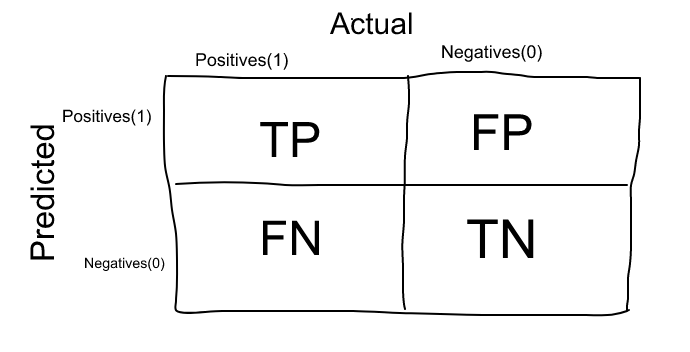
    - TP: True positiv; prediction says 1, truth is 1
    - TN: True negatives; prediction says 0, truth is 0
    - FP: False positives; prediciton says 1, truth is 0
    - FN: False negatives; prediction says 0, truth is 1


- Accuracy = (TP+TN)/(TP+TN+FP+FN)
- Precision = TP/(TP+FP)
- Recall
- Specifity
- F1-Score
- Receiver Operating Characteristic (ROC)
- ...

In [ ]:
algo_names = ['y_pred_gnb', 'y_pred_dt', 'y_pred_rf', 'y_pred_mlp']
algo_pred = pd.DataFrame([y_pred_gnb, y_pred_dt, y_pred_rf, y_pred_mlp]).T
algo_pred.columns = algo_names
acc = []
prec = []

for i, name in enumerate(algo_names):
    calculate_results(algo_pred[name], x_test, y_test, name, algo_pred[name])
    print('Confusion matrix:\n')
    print(confusion_matrix(y_test, algo_pred[name]), '\n')
    print('Classification Report:')
    print(classification_report(y_test, algo_pred[name]))
    print('---------------------------------------------------------------------')
    # Save all accuracy results in a list (you could do this for every result)
    acc.append(metrics.accuracy_score(y_test, algo_pred[name]))
    prec.append(metrics.precision_score(y_test, algo_pred[name]))

In [ ]:
# Run this section only once!
accuracies = pd.DataFrame()
precision = pd.DataFrame()

Finally we save the desired performance metrics (Accuracy) in a dataframe, for example for visualization purposes

In [ ]:
accuracies['pca_movingmean'] = acc
precision['pca_movingmean'] = prec
accuracies

In [ ]:
accuracies.columns[0:3]

In [ ]:
# colors = 
plt.figure(figsize=(8,4))
for counter, i in enumerate(accuracies.columns):
    plt.scatter(accuracies.index, accuracies[i], label=i, marker='o', c='C{}'.format(counter))
    plt.scatter(precision.index,  precision[i], marker='v', c='C{}'.format(counter))
plt.scatter(0,0,marker='o', c='k', label='Accuracy')
plt.scatter(0,0,marker='v', c='k', label='Precision')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0.55, 1.05)
plt.xticks(accuracies.index, algo_names)
plt.xlabel('Algorithm')
plt.ylabel('Accuracy / Precision')

You could try also other algorithms, as for example Support Vector machines. But this would take a moment longer.

In [ ]:
clf = svm.SVC(kernel="rbf", probability=True)
type = "Support Vector Machine"
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
y_pred_prob = clf.predict_proba(x_test)


# joblib.dump(clf, "trained_svm_1.pkl")
calculate_results(y_pred, x_test, y_test, type, y_pred_prob)